In [1]:
from azureml.core import Workspace

ws = Workspace.from_config(_file_name='C:\\Users\\nargesBassir\\Desktop\\final project\\config\\config_final_project.json')

In [2]:
import mlflow

mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())

# Set mlflow tracking URI to your local mlflow tracking server
#mlflow.set_tracking_uri("http://localhost:5000")

- Set Experiment name in mlflow
    - An experiment can have multiple runs so experiment provides an easy way to capture multiple runs

In [3]:
# This API will set the experiment name in MLFLow. If the experiment does't exist then it will create it
mlflow.set_experiment("final project")

#### Core ML experiment code

In [4]:
# ADD THIS TO IMPORT MLFLOW FOR SKLEARN MODULES
#import mlflow.sklearn

from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [5]:
fp = pd.read_csv('C:\\Users\\nargesBassir\\Desktop\\final project\\data\\fp_dataset.csv')
fp.head()

,id_number,Clump_Thickness,Uniformity_Cell_Size,Uniformity_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [6]:
#data preparation
fp["class"]=fp["class"].replace([4,2],[1,0])
fp.head()

,id_number,Clump_Thickness,Uniformity_Cell_Size,Uniformity_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,0
1,1002945,5,4,4,5,7,10,3,2,1,0
2,1015425,3,1,1,1,2,2,3,1,1,0
3,1016277,6,8,8,1,3,4,3,7,1,0
4,1017023,4,1,1,3,2,1,3,1,1,0


In [7]:
fp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   id_number                    699 non-null    int64 
 1   Clump_Thickness              699 non-null    int64 
 2   Uniformity_Cell_Size         699 non-null    int64 
 3   Uniformity_Cell_Shape        699 non-null    int64 
 4   Marginal_Adhesion            699 non-null    int64 
 5   Single_Epithelial_Cell_Size  699 non-null    int64 
 6   Bare_Nuclei                  699 non-null    object
 7   Bland_Chromatin              699 non-null    int64 
 8   Normal_Nucleoli              699 non-null    int64 
 9   Mitoses                      699 non-null    int64 
 10  class                        699 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 60.2+ KB


In [8]:
fp.isna().sum()


id_number                      0
Clump_Thickness                0
Uniformity_Cell_Size           0
Uniformity_Cell_Shape          0
Marginal_Adhesion              0
Single_Epithelial_Cell_Size    0
Bare_Nuclei                    0
Bland_Chromatin                0
Normal_Nucleoli                0
Mitoses                        0
class                          0
dtype: int64

In [9]:

# split 80/20 train-test
X_train, X_test, y_train, y_test = train_test_split(fp.drop(['class','Bare_Nuclei','id_number'],axis=1),
                                                    fp["class"],
                                                    test_size=0.2,
                                                    random_state=1)

In [12]:
X_train.head(3)
# y_train.head(3)

,Clump_Thickness,Uniformity_Cell_Size,Uniformity_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bland_Chromatin,Normal_Nucleoli,Mitoses
617,1,1,1,1,1,1,1,1
107,1,6,8,10,8,5,7,1
17,4,1,1,1,2,3,1,1


### Lasso Regressor and feature selection
    - Specify the Lasso Regression model, and select a suitable alpha (equivalent of penalty). The bigger the alpha the less features that will be selected.
    - **For end-to-end demo purpose & simplicity, we are setting high value of alpha to select least number of features**

In [13]:
# Feature Selection
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

In [14]:
# remember to set the seed, the random state in this function
sel_ = SelectFromModel(Lasso(alpha=0.3, random_state=365))

# train Lasso model and select features
lasso = sel_.fit(X_train, y_train)

In [15]:
# this is how we can make a list of the selected features
selected_feats = X_train.columns[(sel_.get_support())]

# let's print selected features
print('total features: ', X_train.shape[1], "   selected features: ", len(selected_feats))
print('selected features: ', selected_feats)

total features:  8    selected features:  5
selected features:  Index(['Clump_Thickness', 'Uniformity_Cell_Size', 'Uniformity_Cell_Shape',
       'Marginal_Adhesion', 'Normal_Nucleoli'],
      dtype='object')


#### We will only use above selected feature from this point onward

In [16]:
X_train = X_train[selected_feats]
X_test = X_test[selected_feats]
X_train.head(3)

,Clump_Thickness,Uniformity_Cell_Size,Uniformity_Cell_Shape,Marginal_Adhesion,Normal_Nucleoli
617,1,1,1,1,1
107,1,6,8,10,7
17,4,1,1,1,1


### Tracking Parameters, Metrics, and Artifacts
Side Note To log artifacts, we have to save them somewhere before MLflow can log them. This code accomplishes that by using a temporary file that it then deletes.

In [17]:
import os
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score


test_models = [LogisticRegression(random_state = 0),
            KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2),
            SVC(kernel = 'rbf', random_state = 0),
            GaussianNB(),
            DecisionTreeClassifier(criterion="entropy", random_state=0),
            RandomForestClassifier(n_estimators= 100, criterion="entropy", random_state=0)]

def model_test(Model):
    model_type = type(Model).__name__
    print(model_type)
    Model.fit(X_train, y_train)

    run_name = "Basic " + model_type + " Experiment"
    print(run_name)
    with mlflow.start_run(run_name=run_name) as run:

        Model.fit(X_train, y_train)
        y_pred = Model.predict(X_test)

        cm = confusion_matrix(y_test, y_pred)
        print(cm)

        df_cm = pd.DataFrame(cm, index = ["T", "F"],
                  columns = ["T", "F"])
        plt.figure(figsize = (5,5))
        sns.heatmap(df_cm, annot=True)
        figname = "Confusion_Matrix_" + model_type
        # Log CM
        plt.savefig(figname)
        mlflow.log_artifact("CMs/"+figname+".png")

        score = accuracy_score(y_test, y_pred)

        # Log model
        mlflow.sklearn.log_model(Model, model_type+"-model")

        # Create metrics
        print(f"score: {score}")

        # Log metrics
        mlflow.log_metric("score", score)

        runID = run.info.run_uuid
        experimentID = run.info.experiment_id

        print(f"Inside MLflow Run with run_id `{runID}` and experiment_id `{experimentID}`")

Inside MLFlow Run with Run_id `763e961b-56d9-4088-9d3e-6f42cf3f3e32` exp_id `33d764ea-2bf6-4fb8-9792-361efacb1efc`


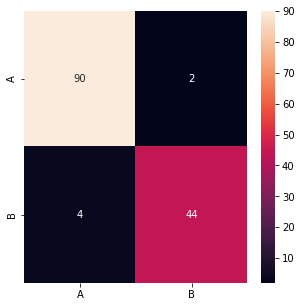

In [18]:
with mlflow.start_run(run_name="final project") as run:
    log_reg = LogisticRegression()
    log_reg.fit(X_train, y_train)
    y_pred = log_reg.predict(X_test)
    
    mlflow.sklearn.log_model(log_reg, "LogisticRegression")
    
    cm = confusion_matrix(y_test, y_pred)
    
    score = log_reg.score(X_test, y_test)
    
    df_cm = pd.DataFrame(cm, index = ["A", "B"],
                  columns = ["A", "B"])
    plt.figure(figsize = (5,5))
    sn.heatmap(df_cm, annot=True)
    plt.savefig("Confusion Matrix LogReg")
    mlflow.log_artifact("Confusion Matrix LogReg.png")
        
    mlflow.log_metric("score", score)
    
    runID = run.info.run_uuid
    experimentID = run.info.experiment_id
    print(f"Inside MLFlow Run with Run_id `{runID}` exp_id `{experimentID}`")

Inside MLFlow Run with Run_id `03836d62-2427-41c7-bd40-8ba2121af411` exp_id `33d764ea-2bf6-4fb8-9792-361efacb1efc`


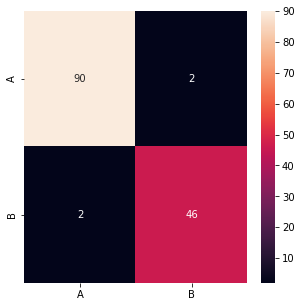

In [19]:
with mlflow.start_run(run_name="final project") as run:
    log_reg = RandomForestClassifier()
    log_reg.fit(X_train, y_train)
    y_pred = log_reg.predict(X_test)
    
    mlflow.sklearn.log_model(log_reg, "RandomForestClassifier")
    
    cm = confusion_matrix(y_test, y_pred)
    
    score = log_reg.score(X_test, y_test)
    
    df_cm = pd.DataFrame(cm, index = ["A", "B"],
                  columns = ["A", "B"])
    plt.figure(figsize = (5,5))
    sn.heatmap(df_cm, annot=True)
    plt.savefig("Confusion Matrix LogReg")
    mlflow.log_artifact("Confusion Matrix LogReg.png")
        
    mlflow.log_metric("score", score)
    
    runID = run.info.run_uuid
    experimentID = run.info.experiment_id
    print(f"Inside MLFlow Run with Run_id `{runID}` exp_id `{experimentID}`")

Inside MLFlow Run with Run_id `8c1ac28a-7497-48ce-986b-214072d3ec8d` exp_id `33d764ea-2bf6-4fb8-9792-361efacb1efc`


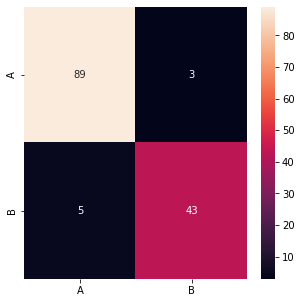

In [20]:
with mlflow.start_run(run_name="final project") as run:
    log_reg = DecisionTreeClassifier()
    log_reg.fit(X_train, y_train)
    y_pred = log_reg.predict(X_test)
    
    mlflow.sklearn.log_model(log_reg, "DecisionTreeClassifier")
    
    cm = confusion_matrix(y_test, y_pred)
    
    score = log_reg.score(X_test, y_test)
    
    df_cm = pd.DataFrame(cm, index = ["A", "B"],
                  columns = ["A", "B"])
    plt.figure(figsize = (5,5))
    sn.heatmap(df_cm, annot=True)
    plt.savefig("Confusion Matrix LogReg")
    mlflow.log_artifact("Confusion Matrix LogReg.png")
        
    mlflow.log_metric("score", score)
    
    runID = run.info.run_uuid
    experimentID = run.info.experiment_id
    print(f"Inside MLFlow Run with Run_id `{runID}` exp_id `{experimentID}`")

Inside MLFlow Run with Run_id `709e0544-9f82-4320-a8e7-f0cd9dbfcc26` exp_id `33d764ea-2bf6-4fb8-9792-361efacb1efc`


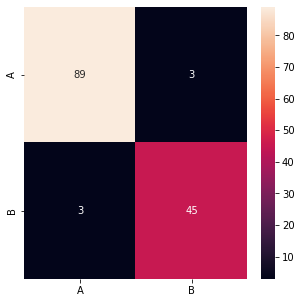

In [21]:
with mlflow.start_run(run_name="final project") as run:
    log_reg = KNeighborsClassifier()
    log_reg.fit(X_train, y_train)
    y_pred = log_reg.predict(X_test)
    
    mlflow.sklearn.log_model(log_reg, "KNeighborsClassifier")
    
    cm = confusion_matrix(y_test, y_pred)
    
    score = log_reg.score(X_test, y_test)
    
    df_cm = pd.DataFrame(cm, index = ["A", "B"],
                  columns = ["A", "B"])
    plt.figure(figsize = (5,5))
    sn.heatmap(df_cm, annot=True)
    plt.savefig("Confusion Matrix LogReg")
    mlflow.log_artifact("Confusion Matrix LogReg.png")
        
    mlflow.log_metric("score", score)
    
    runID = run.info.run_uuid
    experimentID = run.info.experiment_id
    print(f"Inside MLFlow Run with Run_id `{runID}` exp_id `{experimentID}`")

def log_rf(run_name, params, X_train, X_test, y_train, y_test):
# Start run for MLFLOW
  with mlflow.start_run(run_name=run_name) as run:
    # Create model, train it, and create predictions
    rf = RandomForestRegressor(**params)
    rf.fit(X_train, y_train)
    predictions = rf.predict(X_test)

    # Log model to MLFLOW
    mlflow.sklearn.log_model(rf, "random-forest-model")

    # Log params
    mlflow.log_params(params)

    # Create metrics
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    # Log metrics to MLFLOW
    mlflow.log_metrics({"mse": mse, "mae": mae, "r2": r2})   
    
    print("RandomForestRegressor: mse: ", mse, " mae: ", mae, " r2: ", r2)
    print("RandomForestRegressor RunID: ", run.info.run_uuid)
    
    return run.info.run_uuid

- Run experiment with few tuning parameters now

params = {
  "n_estimators": 102,
  "max_depth": 5,
  "random_state": 42
}

runid_log_rf = log_rf("RandomForestRegressor", params, X_train, X_test, y_train, y_test)

def log_lr(run_name, X_train, X_test, y_train, y_test):
# Start run for MLFLOW
  with mlflow.start_run(run_name=run_name) as run:
    # Create model, train it, and create predictions
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    predictions = lr.predict(X_test)

    # Log model to MLFLOW
    mlflow.sklearn.log_model(lr, "random-forest-model")

    # Log params
    mlflow.log_params(params)

    # Create metrics
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    # Log metrics to MLFLOW
    mlflow.log_metrics({"mse": mse, "mae": mae, "r2": r2})   
    
    print("LinearRegression: mse: ", mse, " mae: ", mae, " r2: ", r2)
    print("LinearRegression RunID: ", run.info.run_uuid)
    
    return run.info.run_uuid

runid_log_lr = log_lr("LinearRegression", X_train, X_test, y_train, y_test)

LinearRegression: mse:  0.6502974404299421  mae:  0.6010208728645785  r2:  0.5042296409845219
LinearRegression RunID:  c0cc6c09-2827-41b4-90f1-1865ca0fde9a

RandomForestRegressor: mse:  0.4972648759958899  mae:  0.5226762345813804  r2:  0.6208978064940905
RandomForestRegressor RunID:  b93a595b-0868-4950-9075-d5aed00df151
    
**We will use the RandomForest model since it has better score. RunID: b93a595b-0868-4950-9075-d5aed00df151**

# Step 2: Model REST API Development

- We will start with downloading the trained model from mlflow server. REMEMBER: MLflow is your centralized experiment repository so use that as the source of truth

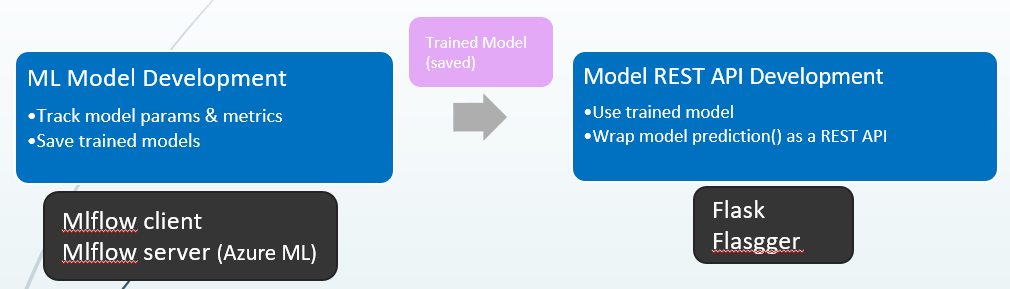

In [22]:
# Use the same experiment name that was specified above
experiment_name = 'final project'

# gets the list of runs for your experiment as an array
#exp = ws.experiments[experiment_name]
#runs = list(exp.get_runs())
#ws.experiments

#### Download model artifacts

In [23]:
# Grab this from your training experiment where you logged the model
runid = "4336c513-0de4-4afb-92ba-b0464f7066aa"
model_path = 'RandomForestClassifier'

model_uri='runs:/{}/{}'.format(runid, model_path)

In [24]:
from mlflow.tracking.artifact_utils import _download_artifact_from_uri

absolute_model_path = _download_artifact_from_uri(model_uri, "C:\\Users\\nargesBassir\\Desktop\\final project\\deployments")

In [25]:
print("Model artifacts downloaded to: ", absolute_model_path)

Model artifacts downloaded to:  C:\Users\nargesBassir\Desktop\final project\deployments\RandomForestClassifier


### Do following things at this point:
- Create a Flask application to wrap model prediction function as a REST API web service
- Your flask app should use the model that was saved under **deployments/cahouseprice_container/** directory
- Test the flask app locally. Sample code is provided under **deployments/cahouseprice_container/api/ca_houseprice_prediction_flask.py**
- Below is a successful output example when api/ca_houseprice_prediction_flask.py is run locally

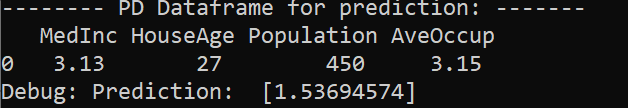

**If your flask app runs successfully on the local machine then move to the next step**

# Step 3: Containerize Model REST API
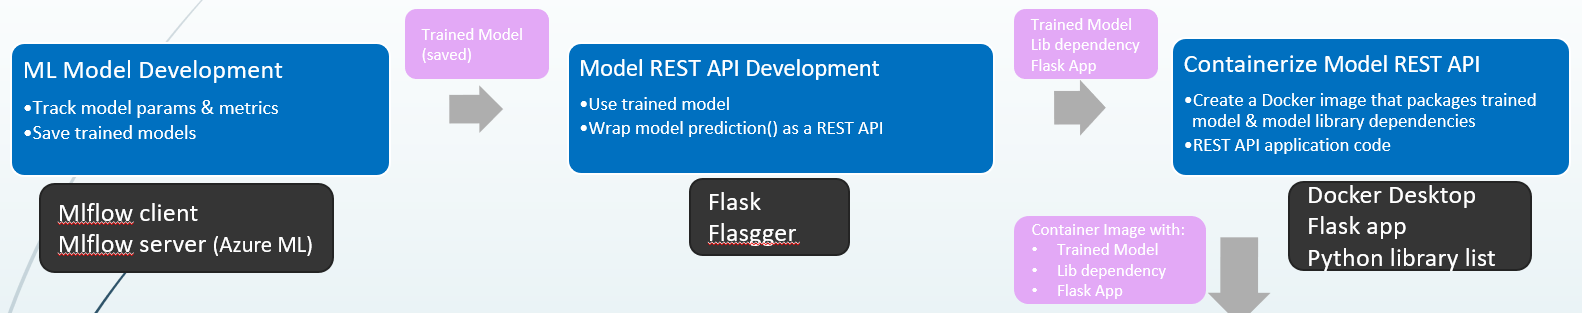

### Do following things at this point:
- Create a **Dockerfile** - Use the python version and dependency captured in mlflow
    - Sample working Dockerfile is provided under deployments/cahouseprice_container
- Create a requirements.txt file - Use dependency captured in mlflow
    - Sample requirements.txt file is provided under deployments/cahouseprice_container/api directory
- Run "docker build" command and verify container builds successfully on local machine
    - Example: **docker build -t cahouseprice-api .**
- Run container on local machine using "docker run" and invoke the REST API endpoint hosted by the container from a web browser
    - Example: **docker run -p 5010:5010 cahouseprice-api**

# Step 4: Register Container to a Registry
- Now that you have successfully built docker image locally and tested it, let's register it to your private container registry
- In this example, we are using Azure Container Registry (ACR)

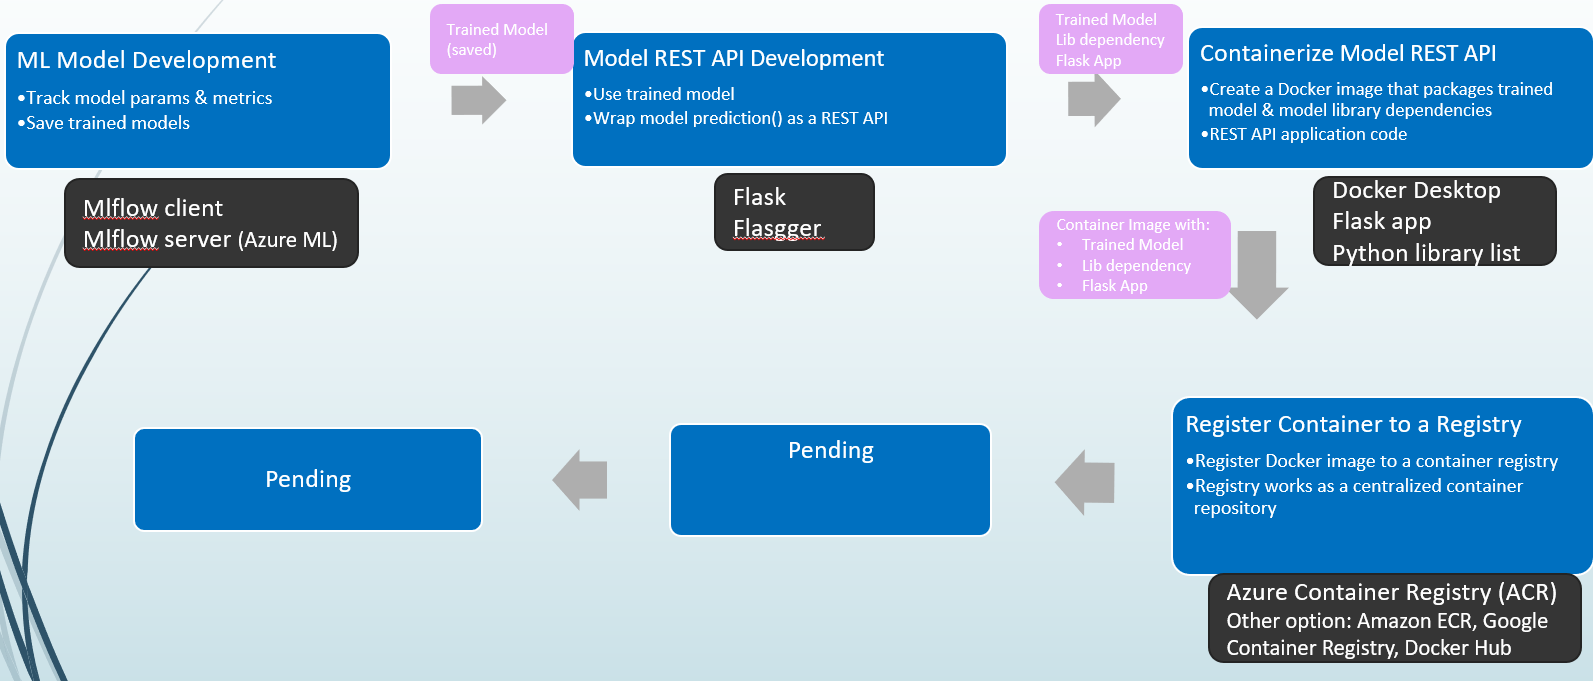



#### NOTE: You can directly run commands below from Jupyter notebook if you have Azure CLI installed

**Step 4.1 Login to Azure via CLI! The command below will bring up a new browser window to sign in**

In [ ]:
!az login

**Step 4.2 Get your Azure Container Registry name** from Azure Portal OR list the container registry for your Azure ML workspace: 
    - az ml workspace show -w <myworkspace> -g <resourcegroup> --query containerRegistry
    
**Step 4.3 Authenticate to the Azure Container Registry (ACR)**  
    - az acr login --name <registry_name>

In [ ]:
!az acr login --name azuremleastu0eaa1e53

**Step 4.4 To build and register your docker image with Azure container registry**, use the following command. 
    - Replace <registry_name> with the name of the container registry you want to store the image in
    - az acr build --image myimage:v1 --registry <registry_name> --file Dockerfile .

In [ ]:
!az acr build --image cahouseprice --registry azuremleastu0eaa1e53 --file ../deployments/cahouseprice_container/Dockerfile ../deployments/cahouseprice_container/

**You should see a message indicating successful run. For example "Run ID: ca5 was successful after 2m26s"**
- This indicates your docker container image was successfully built and registered on the ACR

**Step 4.5 See the newly registered image via command line**
    - List images in container registry using command below: 
        - az acr repository list --name <acrName>

In [ ]:
!az acr repository list --name azuremleastu0eaa1e53

**"cahouseprice" container image is successfully built and registered as in output above. Step 4 completed**

# Step 5: Run Docker Container with Model on Azure Kubernetes cluster

**Step 5.1 - Create Azure Kubernetes Service (AKS) cluster using Azure Portal**
    - Detailed instructions to create AKS provided in classnotes

**Step 5.2 Install Azure Kubernetes CLI** 
    - On the command line, run “az aks install-cli”

In [ ]:
!az aks get-credentials --resource-group kubernetesmlrg --name ackuberetesclr

**Verify connection to your AKS cluster using kubectl**
- Run command below


In [ ]:
!kubectl get nodes

**Step 5.3 Create Kubernetes manifest file**
- A sample manifest file is provided at deployments/azurekubernetes_deploy/cahouseprice_aks.yaml
- Azure Container Registry (ACR) instance stores the container image for the ML model and REST API flask application. To deploy the application, you must update the image name in the Kubernetes manifest file to include the ACR login server name. Get the ACR login server name using the az acr list command as follows:

In [ ]:
!az acr list --resource-group azuremleastusrg --query "[].{acrLoginServer:loginServer}" --output table

**Step 5.4: Deploy & Run your container on Kubernetes cluster**
    - To deploy your model prediction application (which is packaged in docker container), use the kubectl apply command. 
    - This command parses the manifest file and creates the defined Kubernetes objects. Specify the sample manifest file

In [ ]:
!kubectl apply -f ../deployments/azurekubernetes_deploy/cahouseprice_aks.yaml

You should see a message if the service was successfully created. Example: "service/cahouseprice-prediction created"

**Step 5.5: Verify your container (application) deployment on Kubernetes**
- When the application runs, a Kubernetes service exposes the application front end to the internet. This process can take a few minutes to complete. 
- The following example output shows a valid public IP address assigned to the service. 
- When you see this, your custom container (with trained model and flask app) is successfully deployed to a Kubernetes cluster on cloud. 
    - Which means, your model prediction service is ready and can be used from anywhere using the External IP address:


In [ ]:
!kubectl get service cahouseprice-prediction

# Step 6: Use your model prediction service running in the cloud on Kubernetes cluster
- Open browser and invoke your model prediction service using external IP and port. 
    - Example http://52.226.3.223:5010/apidocs/ as screenshot below

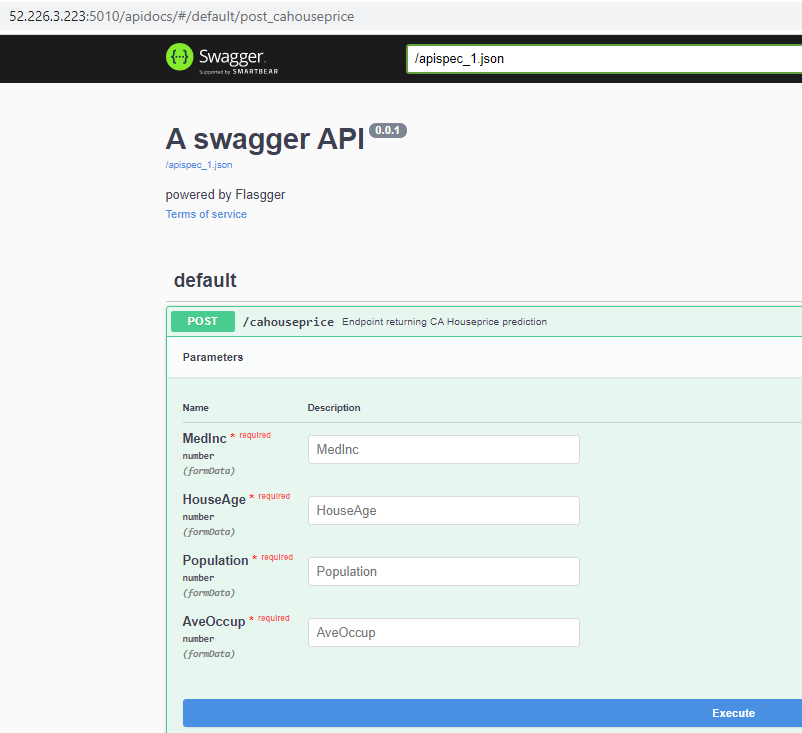

## Congratulations!! 
You have successfully completed ML model deployment on the cloud platform using one of the most common and scalable deployment option! Using the most popular open source tools!

## This example implemented following end-to-end process
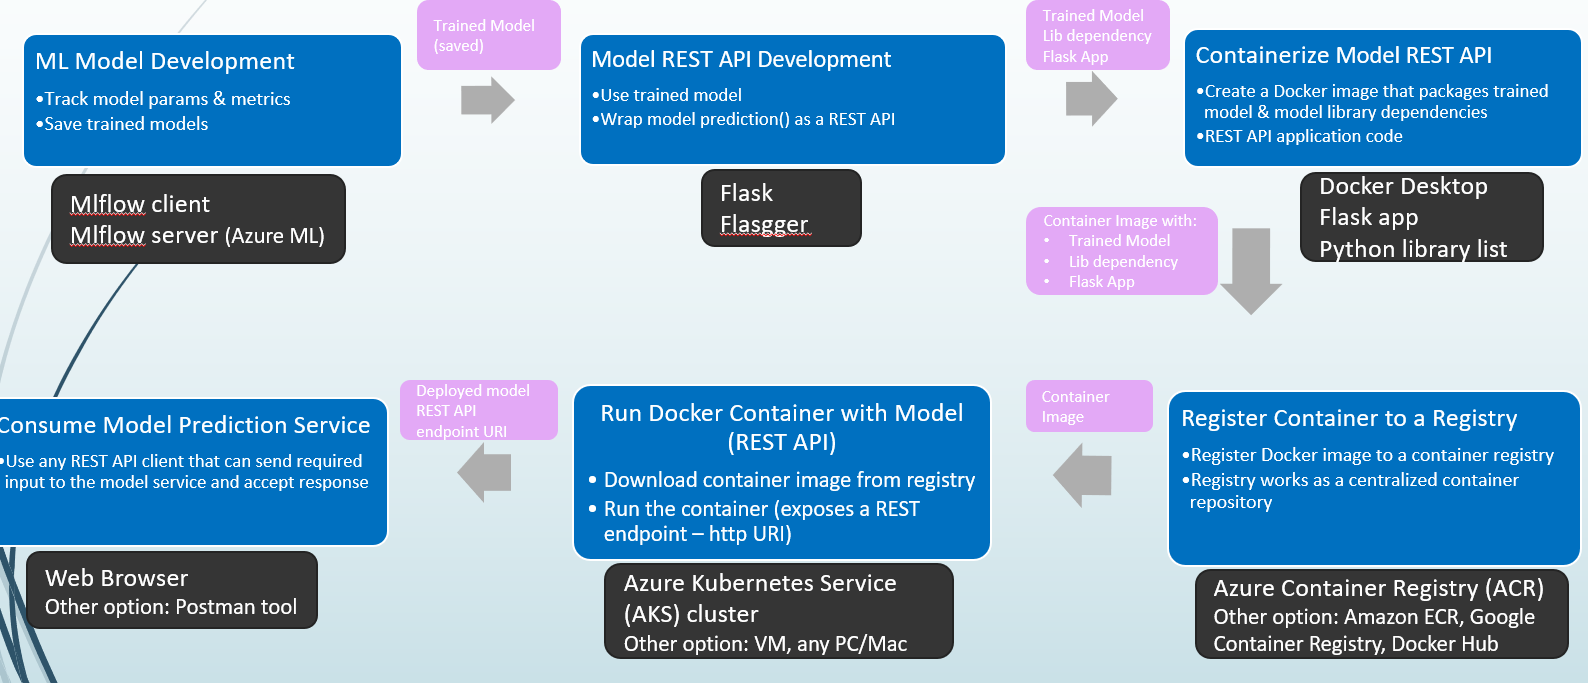